This notebook makes the final figures for the liver cirrhosis case study. I'll mostly be copying this from [2018-10-29.cirrhosis_bn10_metabolomics_figures.ipynb](2018-10-29.cirrhosis_bn10_metabolomics_figures.ipynb) but starting from a different file.

In [1]:
import pandas as pd
import numpy as np
import feather

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')
sns.set_palette(sns.color_palette('muted', n_colors=9)[4:])

In [2]:
ftidy = '../../data/clean/bn10.tidy_metabolomics.feather'
DF = feather.read_dataframe(ftidy)

franks = '../../data/analysis/bn10_metabolomics.donor_ranks.txt'
df_ranks = pd.read_csv(franks, sep='\t')

In [12]:
scfas = ['butyrate', 'isovalerate', 'propionate']
primary_bile = ['cholate', 'chenodeoxycholate']
secondary_bile = ['deoxycholate', 'lithocholate']

all_mlcls = scfas + primary_bile + secondary_bile

df = DF.query('metabolite == @all_mlcls').fillna(0)

# Some donors have multiple samples; take the mean abundance
df = (
    df.groupby(['donor', 'metabolite', ])
      ['intensity']
      .mean()
      .reset_index(name='mean_intensity')
)

# And log it
df['log_intensity'] = np.log10(df['mean_intensity'] + 1.0)

# Distribution of metabolite abundances in all donors


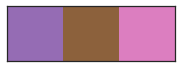

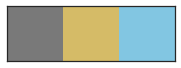

In [13]:
# SCFA palette
sns.palplot(sns.color_palette('muted', n_colors=9)[4:7])

# Bile acid palette
sns.palplot(sns.color_palette('muted', n_colors=10)[7:])

cdict = {i: j for i, j in zip(scfas, sns.color_palette('muted', n_colors=9)[4:7])}
cdict.update(
    {'cholate': sns.color_palette('muted', n_colors=10)[9],
     'deoxycholate': sns.color_palette('muted', n_colors=10)[9],
     'chenodeoxycholate': sns.color_palette('muted', n_colors=10)[8],
     'lithocholate': sns.color_palette('muted', n_colors=10)[8]
    }
)

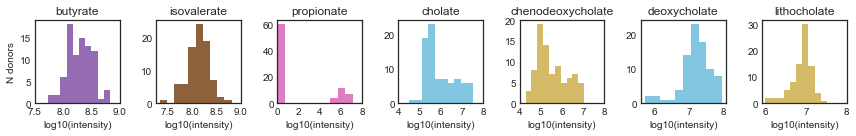

In [18]:
# For paper
fig, ax = plt.subplots(1, 7, figsize=(12, 2))

mlcls = scfas + primary_bile + secondary_bile
#colors = sns.color_palette('muted', n_colors=12)[4:12]

# manually set xticks, gr
xticks = {2: [0, 2, 4, 6, 8],
          1: [7.5, 8, 8.5, 9.0],
          0: [7.5, 8.0, 8.5, 9.0],
          3: [4, 5, 6, 7, 8],
          4: [4, 5, 6, 7, 8],
          5: [6, 7, 8],
          6: [6, 7, 8]}

i = 0
for s in mlcls:
    subdf = df.query('metabolite == @s')
    
    ax[i].hist(subdf['log_intensity'], color=cdict[s], bins=10)
    ax[i].set_title(s)
    
    ax[i].set_xlabel('log10(intensity)')

    if i == 0:
        ax[i].set_ylabel('N donors')
    if i == 2:
        ax[i].set_xlim([0, None])

    ax[i].set_xticks(xticks[i])
    
    i += 1

fig.tight_layout()
fig.savefig('../../figures/final/fig3.scfas_bile_acid_conversion_bn10_donors.distribution.png')

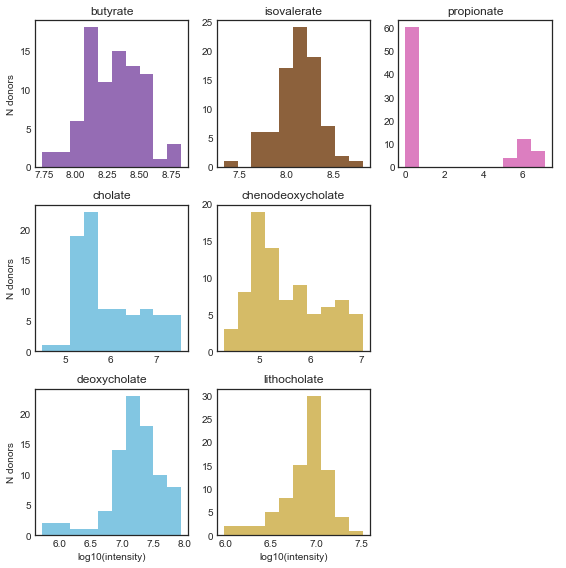

In [19]:
# For presentation slides
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
ax = ax.flatten()

i = 0
for s in scfas + primary_bile + secondary_bile:
    subdf = df.query('metabolite == @s')
    
    ax[i].hist(subdf['log_intensity'], color=cdict[s])
    ax[i].set_title(s)
    
    if i in [6, 7]:
        ax[i].set_xlabel('log10(intensity)')

    if i in [0, 3, 6]:
        ax[i].set_ylabel('N donors')

    i += 1
    if s == "chenodeoxycholate":
        ax[i].set_axis_off()
        i += 1 

ax[i].set_axis_off()
fig.tight_layout()
fig.savefig('../../figures/presentation/fig3.scfas_bile_acid_conversion_bn10_donors.distribution.png')

# Donor rank plots

In [20]:
df_ranks.head()

,donor,total_primary,total_secondary,secondary_to_primary,chenodeoxycholate,lithocholate,lithocholate_chenodeoxycholate,cholate,deoxycholate,deoxycholate_cholate,secondary_to_primary_rank,butyrate,isovalerate,propionate,butyrate_rank,isovalerate_rank,propionate_rank,avg_scfa_rank
0,aa,334637.0,37543130.0,112.190613,184061.0,12237963.0,66.488626,150576.0,25305167.0,168.055779,83.0,282178200.0,404142340.0,0.0,61.0,82.0,1.0,48.000000
1,ab,19465381.0,87420150.0,4.491058,5392116.0,18310021.0,3.395702,14073265.0,69110129.0,4.910739,15.0,673095277.0,247042347.0,3303224.0,83.0,74.0,19.0,58.666667
2,ac,3960029.0,121167477.0,30.597624,2515267.0,32769482.0,13.028232,1444762.0,88397995.0,61.185161,37.0,384704917.0,645391691.0,0.0,78.0,83.0,1.0,54.000000
3,ad,1351986.0,41428909.0,30.643001,330303.5,13652777.0,41.334037,1021682.5,27776132.0,27.186657,38.0,134973918.5,227609496.5,0.0,21.0,72.0,1.0,31.333333
4,ae,7680949.6,47474293.8,6.180784,2374302.0,12352527.6,5.202593,5306647.6,35121766.2,6.618447,18.0,353411777.2,178770944.2,1465210.0,75.0,62.0,4.0,47.000000


In [21]:
# Convert bile ratios to tidy format for easier plotting
ratios = ['secondary_to_primary', 'lithocholate_chenodeoxycholate', 'deoxycholate_cholate']
bile_tidy = df_ranks[['donor'] + ratios].melt(id_vars='donor')
bile_tidy.head()

,donor,variable,value
0,aa,secondary_to_primary,112.190613
1,ab,secondary_to_primary,4.491058
2,ac,secondary_to_primary,30.597624
3,ad,secondary_to_primary,30.643001
4,ae,secondary_to_primary,6.180784


In [22]:
scfa_order = df_ranks.sort_values(by='avg_scfa_rank')['donor']
donor_order_ratio = df_ranks.sort_values(by='secondary_to_primary_rank')['donor']

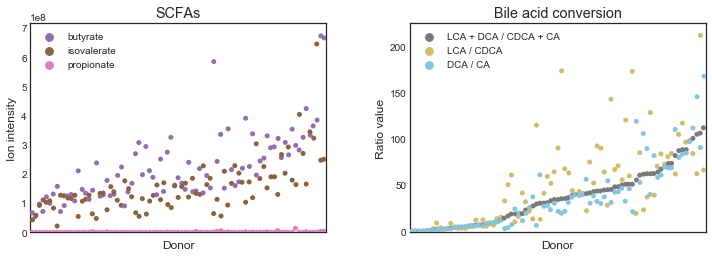

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.stripplot(
    data=df.query('metabolite == @scfas'), 
    x='donor', y='mean_intensity',
    order=scfa_order,
    hue='metabolite',
    ax=ax[0],
    palette=sns.color_palette('muted', n_colors=9)[4:])
ax[0].legend(loc='upper left')
ax[0].set_ylim([-100, None])
ax[0].set_ylabel('Ion intensity', fontsize='large')
ax[0].set_xlabel('Donor', fontsize='large')
ax[0].set_xticklabels('')
ax[0].set_title('SCFAs', fontsize='x-large')

## Bile acid conversion
sns.stripplot(
    data=bile_tidy.query('variable == @ratios'), 
    x='donor', y='value',
    order=donor_order_ratio,
    hue='variable',
    ax=ax[1],
    palette=sns.color_palette('muted', n_colors=10)[7:])

newlabels = ['LCA + DCA / CDCA + CA', 'LCA / CDCA', 'DCA / CA']
handles, _ = ax[1].get_legend_handles_labels()
ax[1].legend(handles, newlabels,
             loc='upper left')
#          loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[1].set_ylim([-1, None])
ax[1].set_xticklabels('')
ax[1].set_xlabel('Donor', fontsize='large')
ax[1].set_ylabel('Ratio value', fontsize='large')
ax[1].set_title('Bile acid conversion', fontsize='x-large')

fig.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=5.0)
fig.savefig('../../figures/final/fig3.scfas_bile_acid_conversion_bn10_donors.ranked.png')

Now looking at donors based on their ranks in both types of data.

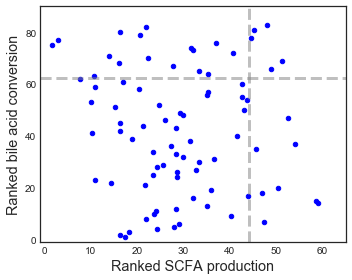

In [39]:
fig, ax = plt.subplots(figsize=(5, 4))

# Prepare cutoff values
percent_cutoff = 0.75
scfa_cutoff = percent_cutoff * df_ranks['avg_scfa_rank'].max()
bile_cutoff = percent_cutoff * df_ranks['secondary_to_primary_rank'].max()

ax.scatter(df_ranks['avg_scfa_rank'], df_ranks['secondary_to_primary_rank'],
           s=20, c='blue')

ax.axvline(scfa_cutoff, alpha=0.5, linestyle='--', c='gray', linewidth=3)
ax.axhline(bile_cutoff, alpha=0.5, linestyle='--', c='gray', linewidth=3)

ax.set_xlim([-1, 65])
ax.set_ylim([-1, 90])

ax.set_xlabel('Ranked SCFA production', fontsize='x-large')
ax.set_ylabel('Ranked bile acid conversion', fontsize='x-large')

fig.tight_layout()
fig.savefig('../../figures/final/fig3.scfas_bile_acid_conversion_bn10_donors.bile_acid_vs_scfa.png')